In [22]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121, InceptionV3, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Paths
train_path = "Training"
testing_path = "Testing"

In [3]:
# Get class count
class_sayisi = len(os.listdir(train_path))
print(f"Sınıf sayısı: {class_sayisi}")

Sınıf sayısı: 4


In [4]:
# Load and preprocess images
def load_images_from_folder(folder_path, image_size=(224, 224)):
    images = []
    labels = []
    for label in range(class_sayisi):
        class_folder = os.path.join(folder_path, str(label))
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = img / 255.0
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [6]:
# Load training data
images, classNo = load_images_from_folder(train_path)
print(f"Görüntüler: {images.shape}")
print(f"Sınıflar: {classNo.shape}")

Görüntüler: (5712, 224, 224, 3)
Sınıflar: (5712,)


In [7]:

# Convert labels to categorical
classNo = to_categorical(classNo, num_classes=class_sayisi)

In [8]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, classNo, test_size=0.2, stratify=classNo, random_state=42)

In [9]:
print(f"Eğitim verileri: {X_train.shape}")
print(f"Doğrulama verileri: {X_val.shape}")

Eğitim verileri: (4569, 224, 224, 3)
Doğrulama verileri: (1143, 224, 224, 3)


In [10]:
# Example of model creation with DenseNet121
def create_model(base_model):
    base = base_model(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(class_sayisi, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=x)
    return model

In [11]:
# Create models
model_densenet = create_model(DenseNet121)
model_inception = create_model(InceptionV3)
model_xception = create_model(Xception)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [12]:
# Compile models
def compile_model(model):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
model_densenet = compile_model(model_densenet)
model_inception = compile_model(model_inception)
model_xception = compile_model(model_xception)

In [14]:
# Train models
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
    return history


In [15]:
# Train models
history_densenet = train_model(model_densenet, X_train, y_train, X_val, y_val)
history_inception = train_model(model_inception, X_train, y_train, X_val, y_val)
history_xception = train_model(model_xception, X_train, y_train, X_val, y_val)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step - accuracy: 0.8243 - loss: 0.5079 - val_accuracy: 0.3456 - val_loss: 8.9148
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 312s 4s/step - accuracy: 0.9542 - loss: 0.1357 - val_accuracy: 0.7454 - val_loss: 1.4948
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 344s 5s/step - accuracy: 0.9599 - loss: 0.1222 - val_accuracy: 0.5976 - val_loss: 2.8938
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 341s 5s/step - accuracy: 0.9715 - loss: 0.0734 - val_accuracy: 0.8618 - val_loss: 0.6635
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 338s 5s/step - accuracy: 0.9774 - loss: 0.0662 - val_accuracy: 0.9326 - val_loss: 0.2258
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 338s 5s/step - accuracy: 0.9839 - loss: 0.0433 - val_accuracy: 0.6947 - val_loss: 1.7333
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 347s 5s/step - accuracy: 0.9847 - loss: 0.0382 - val_accuracy: 0.8828 - val_loss: 0.5293
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 345s 5s/step - accuracy: 0.9897 - loss: 0.0318 - val_accuracy: 0.5319 - v

In [16]:
# Load testing data
X_test, y_test = load_images_from_folder(testing_path)
y_test_categorical = to_categorical(y_test, num_classes=class_sayisi)

In [17]:
# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    return accuracy, cm

In [18]:
accuracy_densenet, cm_densenet = evaluate_model(model_densenet, X_test, y_test_categorical)
accuracy_inception, cm_inception = evaluate_model(model_inception, X_test, y_test_categorical)
accuracy_xception, cm_xception = evaluate_model(model_xception, X_test, y_test_categorical)

41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 508ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 314ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 597ms/step


In [19]:
print(f"DenseNet121 Accuracy: {accuracy_densenet}")
print(f"InceptionV3 Accuracy: {accuracy_inception}")
print(f"Xception Accuracy: {accuracy_xception}")


DenseNet121 Accuracy: 0.8909229595728452
InceptionV3 Accuracy: 0.8924485125858124
Xception Accuracy: 0.7459954233409611


In [20]:
# Plot confusion matrices
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(class_sayisi), yticklabels=range(class_sayisi))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

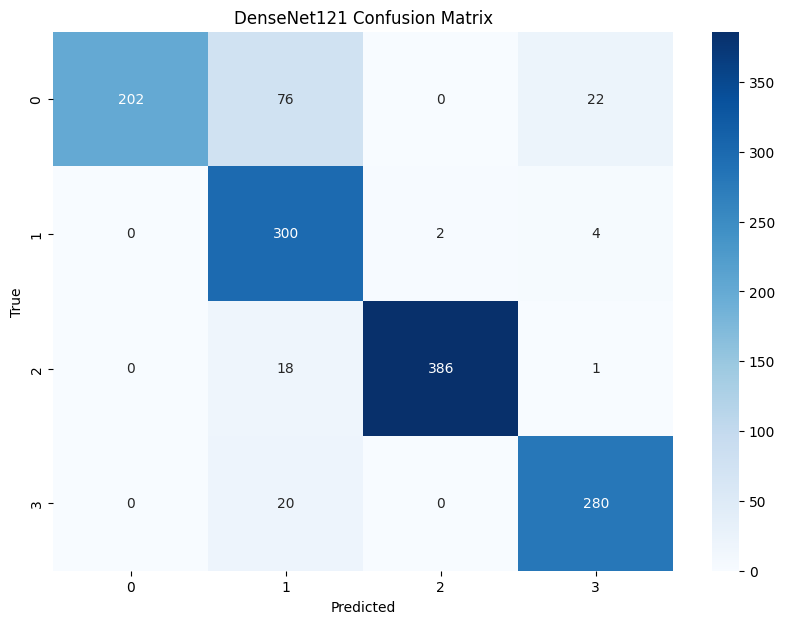

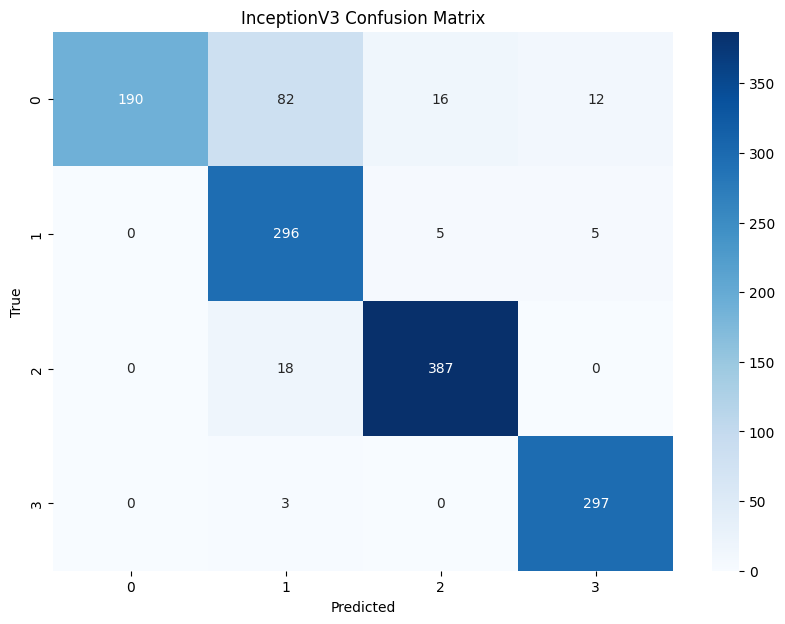

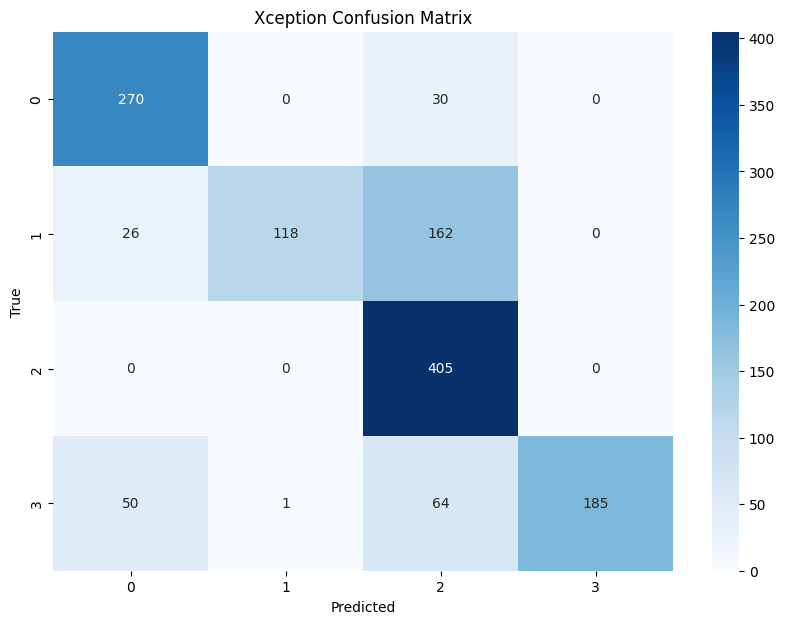

In [24]:
plot_confusion_matrix(cm_densenet, 'DenseNet121 Confusion Matrix')
plot_confusion_matrix(cm_inception, 'InceptionV3 Confusion Matrix')
plot_confusion_matrix(cm_xception, 'Xception Confusion Matrix')

In [25]:
# Soft ensemble
def soft_ensemble(models, X):
    predictions = [model.predict(X) for model in models]
    avg_predictions = np.mean(predictions, axis=0)
    return np.argmax(avg_predictions, axis=1)

In [26]:
# List of trained models
models = [model_densenet, model_inception, model_xception]

In [27]:
# Get ensemble predictions
y_pred_ensemble = soft_ensemble(models, X_test)
y_true_classes = np.argmax(y_test_categorical, axis=1)
accuracy_ensemble = accuracy_score(y_true_classes, y_pred_ensemble)
cm_ensemble = confusion_matrix(y_true_classes, y_pred_ensemble)

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 415ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 536ms/step


In [28]:
print(f"Soft Ensemble Accuracy: {accuracy_ensemble}")

Soft Ensemble Accuracy: 0.9397406559877955


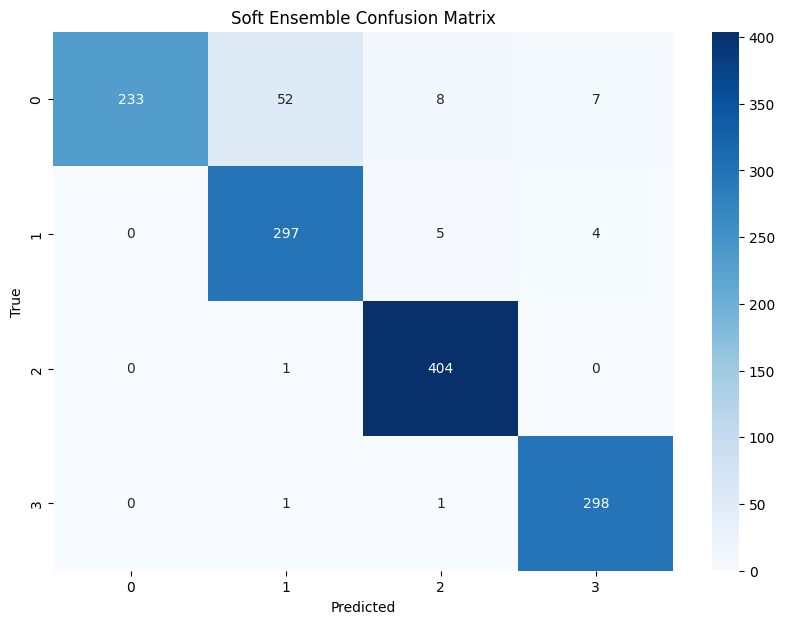

In [29]:
# Plot confusion matrix for ensemble
plot_confusion_matrix(cm_ensemble, 'Soft Ensemble Confusion Matrix')